# Notebook

## Import das bibliotecas necessárias

In [1]:
!pip install segmentation-models-pytorch
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.5 MB/s eta 0:00:0000:01


In [ ]:
import cv2
import torch
import kagglehub
import numpy as np

from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import v2
import torchvision.transforms.functional as TF
from torchvision.io import decode_image
from torchvision.io.image import ImageReadMode
from torch.utils.data import random_split
from torch.utils.data import Subset

from matplotlib import pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

import os
from glob import glob
import json

import segmentation_models_pytorch as smp
from skimage import morphology, measure

DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
DEVICE

'cpu'

## Dataset

Definindo o caminho do dataset de input

In [ ]:
#### SE FOR RODAR NO KAGGLE
# INPUT_DIR = "/kaggle/input/guilhermecastilho222/chest-xray-weak-labels-selfsupervised-learning/output/"
#### SE QUISER RODAR LOCAL OU NO COLAB
INPUT_DIR = kagglehub.dataset_download("guilhermecastilho222/chest-xray-weak-labels-selfsupervised-learning")
INPUT_DIR = os.path.join(INPUT_DIR, "output")

100%|██████████| 10.5G/10.5G [02:40<00:00, 70.3MB/s]

Extracting files...


Definição das funções que geram as weak labels e que calculam o QC (Quality Control).

In [32]:
def generate_weak_mask(img_path):
    # Carrega a imagem e redimenciona
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    img = cv2.resize(img, (512, 512))
    # "Estoura" pixels extremos para que não entrem na máscara
    img[img < 50] = 255 
    img[img > 180] = 255
    
    # Equalização + suavização
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    I = clahe.apply(img)
    I = cv2.GaussianBlur(I, (7,7), 0)
    
    for ang in np.arange(0, 151, 30):
        se = np.zeros((15, 15), np.uint8)
        cv2.ellipse(se, (15//2, 15//2), (15//2, 1), ang, 0, 360, 1, -1)
        I_supp = cv2.morphologyEx(I, cv2.MORPH_OPEN, se)
        I = cv2.min(I, I_supp)
        
    # Inverte para que opacidades fiquem claras
    I_inv = cv2.normalize(255 - I, None, 0, 255, cv2.NORM_MINMAX)

    # Filtro bilateral
    I_inv_bilateral = cv2.bilateralFilter(I_inv.astype(np.uint8), d=-1, sigmaColor=0.25*255, sigmaSpace=15)

    # Aplica um treshold simples
    _, bw = cv2.threshold(I_inv_bilateral, 127, 255, cv2.THRESH_BINARY)
    
    # Limpa regiões fora dos pulmões
    # remove um pequeno pedaço do topo e das laterais que não incluem o pulmão (geralmente)
    bw[:40, :], bw[:, -70:], bw[:, :70] = 0,0, 0
    
    # Morfologia para suavizar
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
    
    # Mantém regiões internas
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bw)
    mask_out = np.zeros_like(bw)
    
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        x,y = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP]
        wc,hc = stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]

        # Descarta regiões no topo e muito pequenas
        if area > 500 and y > 39:
            mask_out[labels == i] = 255

    # Remove objetos pequenos (geralmente ombro ou parte da silhueta lateral)
    mask_out = morphology.remove_small_objects(mask_out.astype(bool), min_size=5000)
    
    # Volta ao tamanho original
    mask_out = mask_out.astype(np.uint8)
    mask_out = cv2.resize(mask_out, (w, h))
    
    return torch.from_numpy(mask_out).unsqueeze(0).float()

# Função QC
def qc_score(mask, min_area=0.04, max_area=0.3, min_ecc=0.4, max_ecc=0.98, max_aspect=0.35, num_obj=2):
    props = measure.regionprops(measure.label(mask[0]))
    # Apenas os 2 maiores objetos (idealmente apenas pulmões)
    props = sorted(props, key=lambda x: x.area, reverse=True)[:2]

    H, W = mask[0].shape

    scores = 0

    try:
        biggest_area = props[0].area
    except:
        print(f"Mascara problemática, Nº de objetos nela: {len(props)}")
        return 0

    for p in props:
        lung_scores = list()
        # Área relativa
        area_frac = p.area / (H * W)
        if area_frac < min_area:
            lung_scores.append(area_frac / min_area)
        elif area_frac > max_area:
            lung_scores.append(max_area / area_frac)
        else:
            lung_scores.append(1.0)

        # Eccentricidade
        ecc = p.eccentricity
        if ecc < min_ecc:
            lung_scores.append(ecc / min_ecc)
        elif ecc > max_ecc:
            lung_scores.append(max_ecc / ecc)
        else:
            lung_scores.append(1.0)

        # Solidity
        lung_scores.append(p.solidity)

        # Extent
        lung_scores.append(p.extent)

        # Aspect ratio
        minr, minc, maxr, maxc = p.bbox
        bbox_h = maxr - minr
        bbox_w = maxc - minc
        aspect = max(bbox_h / (bbox_w + 1e-9), bbox_w / (bbox_h + 1e-9))
        if aspect > max_aspect:
            lung_scores.append(max_aspect / aspect)
        else:
            lung_scores.append(1.0)

        # Nº de objetos
        n_obj = len(props)
        if n_obj > num_obj:
            lung_scores.append(1 / n_obj)
        else:
            lung_scores.append(n_obj / num_obj)
       
        # Soma o score do pulmão ao score final ponderado pela diferença de tamanho entre pulmões 
        scores += np.mean(lung_scores) * (p.area / biggest_area)

    return scores / 2 # Média dos pulmões

Classe de Dataset e Augmentation

In [55]:
class SelfSegCXRDataset(Dataset):
    def __init__(self, dataset_path=INPUT_DIR, image_size=None, augment=None, device=DEVICE):
        self._path_data = dataset_path
        self.images_paths = glob(os.path.join(self._path_data, "images", "*.jpg"))
        self.weak_labels_paths = glob(os.path.join(self._path_data, "weak_labels", "*.png"))

        self.device = device

        if image_size:
            self.resize_image = v2.Resize(size=image_size, interpolation=v2.InterpolationMode.BILINEAR, antialias=True)
            self.resize_mask = v2.Resize(size=image_size, interpolation=v2.InterpolationMode.NEAREST)
        else:
            self.resize_image = lambda x: x
            self.resize_mask = lambda x: x

        self.augment = augment if augment else lambda x, y: (x, y)
   
    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, index):
        image_path = self.images_paths[index]
        mask_path = self.weak_labels_paths[index]

        image = decode_image(image_path).to(torch.float)
        mask = decode_image(mask_path).to(torch.float) / 255.0
        
        qc = qc_score(mask)
        
        image = self.resize_image(image)
        mask = self.resize_mask(mask)

        image, mask = self.augment(image, mask)

        return image, mask, qc
    
class CXRAugmentation:
    def __init__(self, flip_prob=0.5, rotate_prob=0.5, translade_prob=0.5, change_quality_prob=0.3):
        self._flip_prob = flip_prob
        self._rotate_prob = rotate_prob
        self._apply_prob = change_quality_prob
        self._translade_prob = translade_prob

    def apply(self, image, mask):
        augment_list = list()

        if np.random.rand() < self._flip_prob:
            augment_list.append(lambda img, msk: (TF.hflip(img), TF.hflip(msk)))

        if np.random.rand() < self._translade_prob + 1:
            prop_x = float(np.random.choice(np.arange(-5, 5.5, 0.5))) / 100
            prop_y = float(np.random.choice(np.arange(-5, 5.5, 0.5))) / 100

            H, W = image[0].shape
            translate_props = (int(prop_x * W), int(prop_y * H))

            augment_list.append(lambda img, msk: (TF.affine(img, 0, translate_props, 1, (0, 0)), TF.affine(msk, 0, translate_props, 1, (0, 0))))

        if np.random.rand() < self._rotate_prob:
            angle = int(np.random.choice(np.arange(-5, 6)))
            augment_list.append(lambda img, msk: (TF.rotate(img, angle), TF.rotate(msk, angle)))


        if len(augment_list) < 1:
            augment_list.append(lambda x, y: (x, y))

        image, mask = v2.Compose(augment_list)(image, mask)

        image = v2.RandomApply([
            v2.ColorJitter(brightness=0.1, contrast=0.1),
            v2.GaussianBlur(kernel_size=3)
        ], p=self._apply_prob)(image)

        return image, mask

    def __call__(self, image, mask):
        return self.apply(image, mask)

Função para fazer o split do dataset

In [56]:
def get_train_test_split(dataset, test_prop=0.2):
    n_features = len(dataset)

    test_size = round(n_features * test_prop)
    train_size = n_features - test_size

    return random_split(dataset, [train_size, test_size])

Pequeno teste

QC_1 = 0.6734684357263108


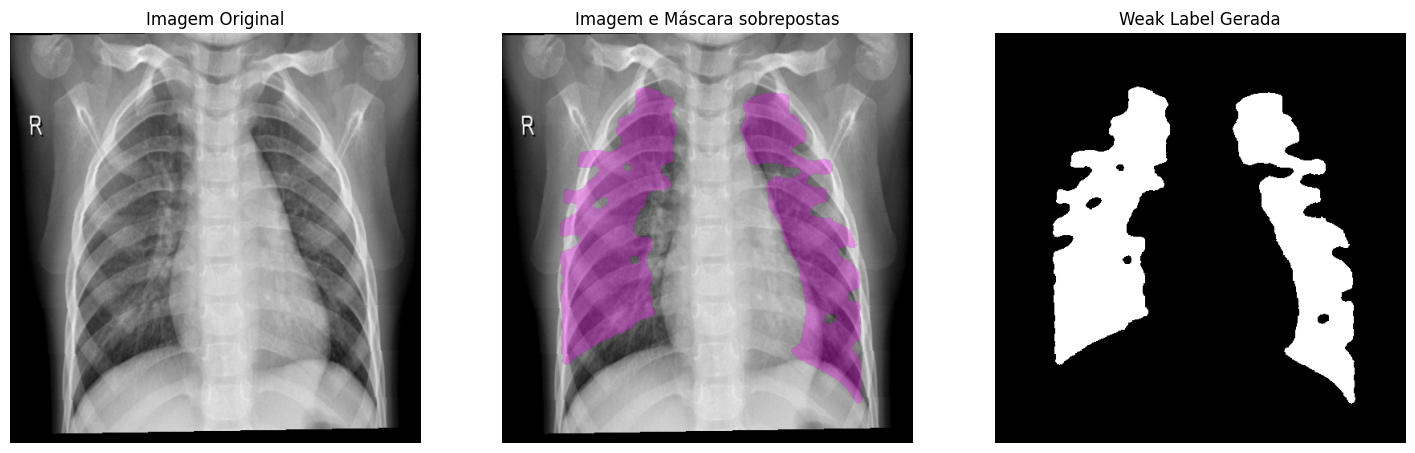

QC_2 = 0.739518267406565


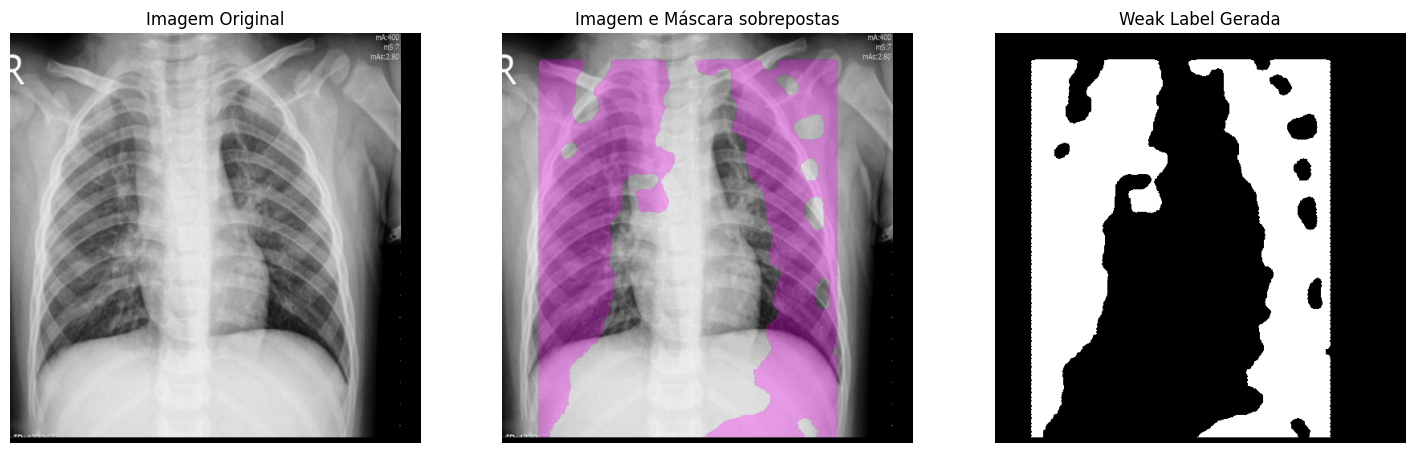

QC_3 = 0.6485591839567363


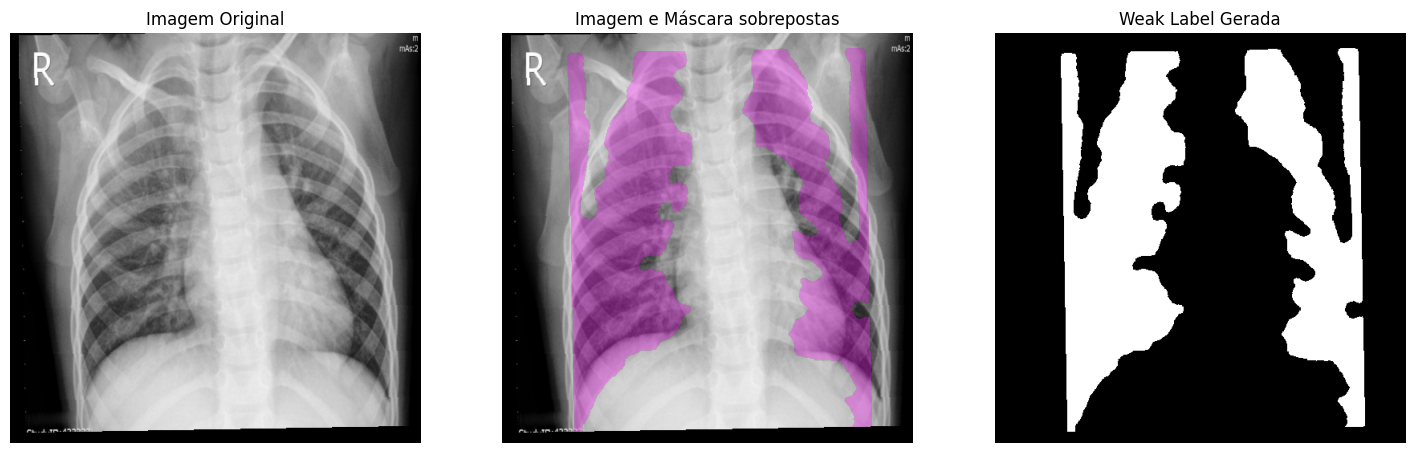

QC_4 = 0.5829982808467256


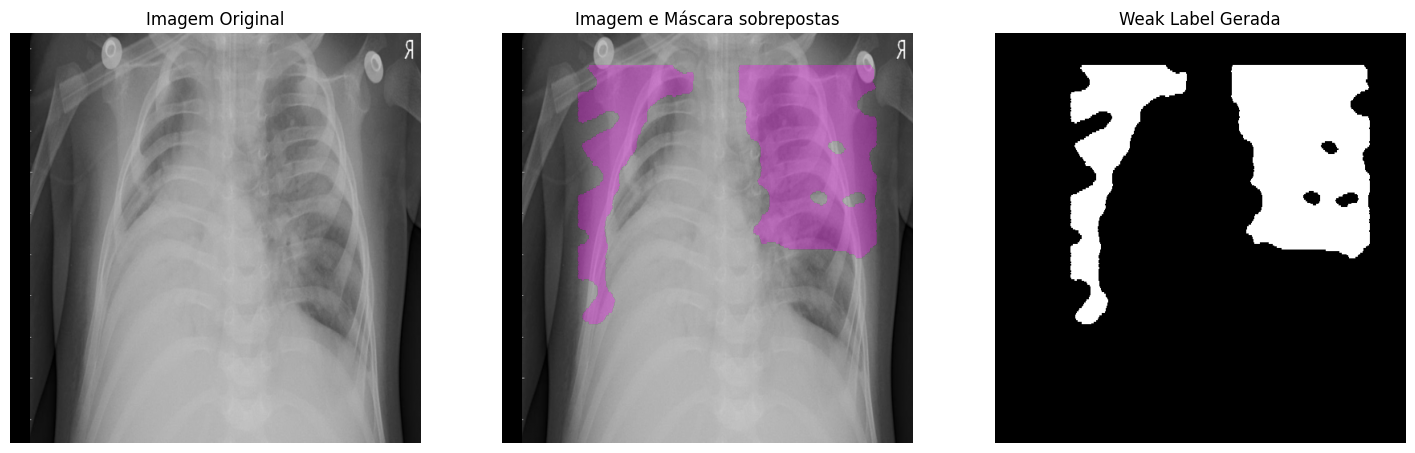

QC_5 = 0.30691634232561826


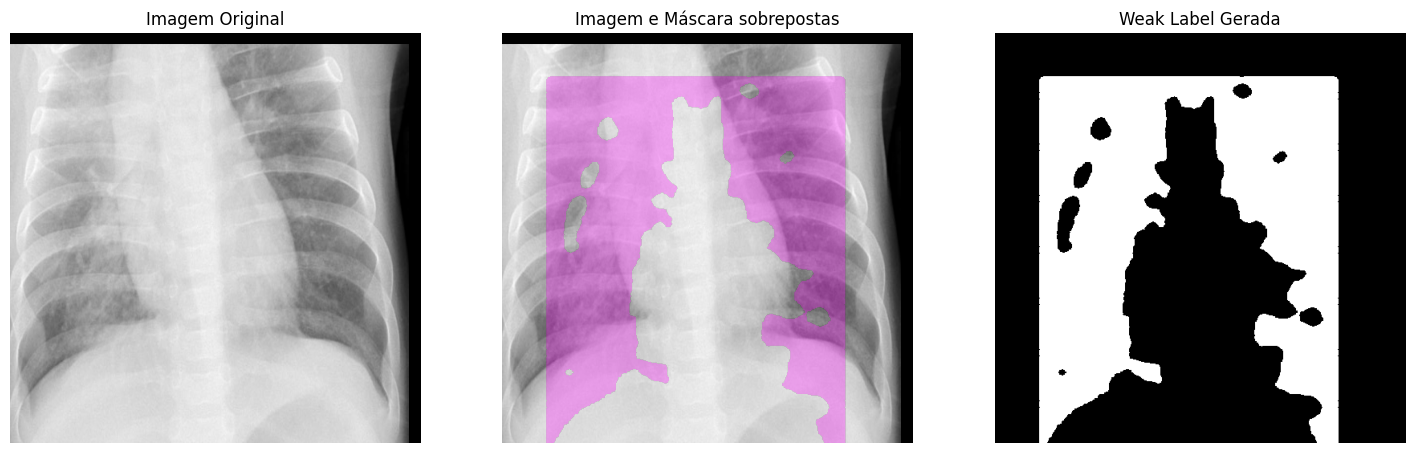

In [ ]:
DATASET = SelfSegCXRDataset(image_size=(512, 512), augment=CXRAugmentation())
DATASET = Subset(DATASET, range(len(DATASET) // 3))

train_ds, test_ds = get_train_test_split(DATASET)

for i in range(5):
    img, mask, qc = train_ds[i]
    
    img, mask = img.cpu()[0], mask.cpu()[0]
    
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.title("Imagem Original")
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Imagem e Máscara sobrepostas")
    plt.imshow(img, cmap="gray")
    masked_overlay = np.ma.masked_where(mask == 0, mask)
    plt.imshow(masked_overlay, cmap = "spring", alpha = 0.3)
    plt.axis("off")
    
    plt.subplot(1,3,3)
    plt.title("Weak Label Gerada")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    print(f"QC_{i+1} = {qc}")
    
    plt.show()

In [ ]:
len(DATASET)

'/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person85_bacteria_417.jpeg'

## UNet

Loss function

In [ ]:
class WeightedSoftDiceLoss(nn.Module):
    def _init_(self, smooth=1e-6):
        super()._init_()
        self.smooth = smooth

    def forward(self, preds, targets, weights=None):
        """
        preds:   [B, 1, H, W]
        targets: [B, 1, H, W]
        weights: [B]
        """

        preds = preds.reshape(preds.size(0), -1)      # [B, HW]
        targets = targets.reshape(targets.size(0), -1)

        intersection = (preds * targets).sum(dim=1)    # [B]
        sums = preds.sum(dim=1) + targets.sum(dim=1)   # [B]

        dice = (2 * intersection + self.smooth) / (sums + self.smooth)  # [B]
        loss = 1 - dice                                                   # [B]

        if weights is not None:
            # normaliza pesos para manter a loss estável
            weights = weights / (weights.sum() + self.smooth)
            loss = loss * weights
            return loss.sum()

        return loss.mean()

Função de treino

In [ ]:
def train_unet(model, train_loader, loss, optimizer, num_epochs=5,
               use_weights=False, device=DEVICE, save_path=None):
    
    model = model.to(device)

    best_loss = float("inf")
    best_state = None

    history_loss = list()

    for epoch in range(num_epochs):
        model.train()
        total = 0

        # print(f"\nIniciando época {epoch + 1}/{num_epochs}")

        # tqdm
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        
        for imgs, masks, qc in progress_bar:
            imgs = imgs.to(device).float()
            masks = masks.to(device)

            # QC opcional como pesos
            if use_weights:
                weights = qc.to(device).float()
            else:
                weights = None

            preds = model(imgs)
            # loss_value = loss(preds, masks, weights=weights)
            loss_value = loss(preds, masks)

            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            total += loss_value.item()

            # Atualiza barra com a loss atual
            progress_bar.set_postfix(loss=loss_value.item())

        epoch_loss = total / len(train_loader)
        print(f"Loss médio da época {epoch + 1}: {epoch_loss:.4f}")
        history_loss.append(epoch_loss)
        # Melhor chackpoint
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_state = model.state_dict()
            # print(f"Novo melhor modelo! Loss = {best_loss:.4f}")

    # Salva modelo
    if save_path is not None and best_state is not None:
        torch.save(best_state, save_path)
        print(f"Modelo salvo (best checkpoint) em: {save_path}")

    return model, history_loss

In [ ]:
def qc_filter(dataset, threshold):
    filtered = list()
    for img, mask, qc in dataset:
        if qc > threshold:
            filtered.append((img, mask, qc))
    return filtered

## Pipeline

In [ ]:
# Early Learning com as weak masks

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation="sigmoid"
)

loss = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_dataset, val_dataset = get_train_test_split(DATASET)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

model = model.to(DEVICE)

threshold = 0.7
MAX_SELF_LEARNING_CYCLE = 5
MIN_DATA = len(DATASET) // 1.5

Self-learning

In [ ]:
train_filtered = qc_filter(train_dataset, threshold)
train_loader_loop = DataLoader(train_filtered, batch_size=16, shuffle=True)

model, loss_1 = train_unet(
    model,
    train_loader_loop,
    loss,
    optimizer,
    num_epochs=5,
    use_weights=False  
)

for i in range(MAX_SELF_LEARNING_CYCLE):
    print(f"iteração nº{i+1}")
    model.eval()
    new_train_data = list()

    with torch.no_grad():
        for img, mask, qc in tqdm(train_dataset, desc="Previsões"):
            img = img.unsqueeze(0).to(DEVICE).float()

            pred = model(img)[0].cpu()
            
            pred_mask = (pred > 0.5).float()

            qc_pred = qc_score(pred_mask)

            if qc_pred > threshold:
                new_train_data.append((img.cpu().squeeze(0), pred_mask.unsqueeze(0), qc_pred))

    print(f"Quantidade de mascaras aprovadas pelo QC: {len(new_train_data)}")
    
    train_loader_loop = DataLoader(new_train_data, batch_size=16, shuffle=True)

    # Re-treina a rede
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model, loss_sl = train_unet(model, train_loader_loop, loss, optimizer)

    # Avaliação no conjunto de validação
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for imgs, masks, qc in val_loader:
            imgs, masks = imgs.to(DEVICE).float(), masks.to(DEVICE)
            preds = model(imgs)
            val_loss += loss(preds, masks).item()

    print(f"Loss médio na validação: {val_loss / len(val_loader):.4f}")

    if len(new_train_data) > MIN_DATA:
        print("Parando")
        break

torch.save(model.state_dict(), "self_learning_unet.pth")

In [ ]:
plt.plot(loss_1)
plt.plot(loss_sl)
plt.plot(val_loss)

In [ ]:
final_train_set = new_train_data
final_train_loader = DataLoader(final_train_set, batch_size=16, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
final_model, loss_final = train_unet(model, final_train_loader, loss, optimizer, num_epochs=3)

final_model.eval()
with torch.no_grad():
    i = 0
    for imgs, masks, qc in val_loader:
        imgs, masks = imgs.to(DEVICE).float(), masks.to(DEVICE)
        preds = final_model(imgs)
        val_loss += loss(preds, masks).item()
        if i%10 == 0:
            for j in range(2):
                img, mask = imgs[j].cpu()[0], preds[j].cpu()[0]
            
                plt.figure(figsize=(18,6))
                plt.subplot(1,3,1)
                plt.title("Imagem Original")
                plt.imshow(img, cmap="gray")
                plt.axis("off")
            
                plt.subplot(1,3,2)
                plt.title("Imagem e Máscara sobrepostas")
                plt.imshow(img, cmap="gray")
                masked_overlay = np.ma.masked_where(mask == 0, mask)
                plt.imshow(masked_overlay, cmap = "spring", alpha = 0.3)
                plt.axis("off")
                
                plt.subplot(1,3,3)
                plt.title("Weak Label Gerada")
                plt.imshow(mask, cmap="gray")
                plt.axis("off")
            
                print(f"QC_{i+1} = {qc[j]}")
                
                plt.show()
            
print(f"Loss médio na validação: {val_loss / len(val_loader):.4f}")

torch.save(final_model.state_dict(), "final_unet.pth")

In [ ]:
plt.plot(loss_final)
plt.plot(val_loss)

In [ ]:
# Plot simples de 20 mascaras aleatórias

random_choice_indexes = np.random.choice(range(len(new_train_data)), 20)

for img, mask, qc in new_train_data[random_choice_indexes]:
    img, mask = img.cpu()[0], mask.cpu()[0][0]
    
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.title("Imagem Original")
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Imagem e Máscara sobrepostas")
    plt.imshow(img, cmap="gray")
    masked_overlay = np.ma.masked_where(mask == 0, mask)
    plt.imshow(masked_overlay, cmap = "spring", alpha = 0.3)
    plt.axis("off")
    
    plt.subplot(1,3,3)
    plt.title("Weak Label Gerada")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    print(f"QC_{i+1} = {qc}")
    
    plt.show()